In [1]:
#Following Link: https://www.analyticsvidhya.com/blog/2021/08/complete-guide-on-how-to-use-lightgbm-in-python/?

In [1]:
import pandas as pd
from sklearn import metrics
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [2]:
#Loading the Data : 
data = pd.read_csv("Cleaned_data_v2/cleaned_car_data_v2.csv")
data = data[data['mileage'] >= 15000]
data.info()

C:\Users\colec\AppData\Local\Temp\ipykernel_3928\3948792460.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("Cleaned_data_v2/cleaned_car_data_v2.csv")


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1211040 entries, 0 to 2528605
Data columns (total 14 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   price           1211040 non-null  float64
 1   body_type       1211040 non-null  object 
 2   exterior_color  1211040 non-null  object 
 3   has_accidents   1211040 non-null  bool   
 4   listed_date     1211040 non-null  object 
 5   make_name       1211040 non-null  object 
 6   mileage         1211040 non-null  float64
 7   model_name      1211040 non-null  object 
 8   owner_count     1211040 non-null  float64
 9   year            1211040 non-null  int64  
 10  dealer_zip      1211040 non-null  object 
 11  major_options   1211040 non-null  object 
 12  trim_name       1211040 non-null  object 
 13  wheel_system    1211040 non-null  object 
dtypes: bool(1), float64(3), int64(1), object(9)
memory usage: 130.5+ MB


In [3]:
ranges = [
    (0, data.price.quantile(.1)),
    (data.price.quantile(.1), data.price.quantile(.2)),
    (data.price.quantile(.2), data.price.quantile(.3)),
    (data.price.quantile(.3), data.price.quantile(.4)),
    (data.price.quantile(.4), data.price.quantile(.5)),
    (data.price.quantile(.5), data.price.quantile(.6)),
    (data.price.quantile(.6), data.price.quantile(.7)),
    (data.price.quantile(.7), data.price.quantile(.8)),
    (data.price.quantile(.8), data.price.quantile(.9)),
    (data.price.quantile(.9), data.price.quantile(1)+1),
]

# ranges = [
#     (0, data.price.quantile(.5)),
#     (data.price.quantile(.5), data.price.quantile(1)+1),
# ]

def findBucket(price):
    val = 0
    for startPrice, EndPrice in ranges:
        if price >= startPrice and price < EndPrice:
            return val
        val += 1

data['bucket'] = data.apply(lambda row: findBucket(row['price']), axis=1)
data['has_accidents'] = data['has_accidents'].astype(bool).astype('int64')

In [4]:
X = data.drop(['price', 'listed_date', 'exterior_color', 'major_options', 'trim_name', 'dealer_zip', 'bucket'],axis=1)
y = data.bucket
print("x dataset:---")
print(X.head())
print("y dataset:---")
print(y.head())


x dataset:---
         body_type  has_accidents   make_name   mileage model_name  \
0  SUV / Crossover              0        Ford  150000.0   Explorer   
1            Sedan              1       Buick  202158.0    Century   
2            Sedan              0       Mazda  213512.0     MAZDA3   
3  SUV / Crossover              0        Jeep  122610.0    Liberty   
4            Sedan              1  Oldsmobile  111111.0      Alero   

   owner_count  year wheel_system  
0          4.0  2005          RWD  
1          5.0  2005          FWD  
2          1.0  2006          FWD  
3          3.0  2002          4WD  
4          1.0  2002          FWD  
y dataset:---
0    0
1    0
2    0
3    0
4    0
Name: bucket, dtype: int64


In [5]:
for c in X.columns:
    col_type = X[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X[c] = X[c].astype('category')
    if col_type == 'float64':
        X[c] = X[c].astype('int64')
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1211040 entries, 0 to 2528605
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype   
---  ------         --------------    -----   
 0   body_type      1211040 non-null  category
 1   has_accidents  1211040 non-null  int64   
 2   make_name      1211040 non-null  category
 3   mileage        1211040 non-null  int64   
 4   model_name     1211040 non-null  category
 5   owner_count    1211040 non-null  int64   
 6   year           1211040 non-null  int64   
 7   wheel_system   1211040 non-null  category
dtypes: category(4), int64(4)
memory usage: 52.0 MB


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=320, stratify=y)

In [7]:
# This allows us to avoid overtraining and we do not need to optimise the number of trees
fit_params={"early_stopping_rounds":10, 
            "eval_metric" : 'logloss', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'feature_name': 'auto', # that's actually the default
            'categorical_feature': 'auto' # that's actually the default
           }

In [8]:
clf = lgb.LGBMClassifier(num_leaves= 1000, max_depth=-1, 
                         random_state=314,  
                         metric='None', 
                         n_jobs=14, 
                         n_estimators=10000,
                         colsample_bytree=1,
                         subsample=0.9,
                         learning_rate=0.05)

In [9]:
clf.fit(X_train, y_train, **fit_params)

c:\Users\colec\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\colec\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\colec\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid's multi_logloss: 2.1414
[2]	valid's multi_logloss: 2.01691
[3]	valid's multi_logloss: 1.91488
[4]	valid's multi_logloss: 1.82883
[5]	valid's multi_logloss: 1.75443
[6]	valid's multi_logloss: 1.68897
[7]	valid's multi_logloss: 1.63116
[8]	valid's multi_logloss: 1.57967
[9]	valid's multi_logloss: 1.53357
[10]	valid's multi_logloss: 1.49184
[11]	valid's multi_logloss: 1.45418
[12]	valid's multi_logloss: 1.41995
[13]	valid's multi_logloss: 1.38862
[14]	valid's multi_logloss: 1.36011
[15]	valid's multi_logloss: 1.33415
[16]	valid's multi_logloss: 1.31022
[17]	valid's multi_logloss: 1.28818
[18]	valid's multi_logloss: 1.26778
[19]	valid's multi_logloss: 1.24895
[20]	valid's multi_logloss: 1.23161
[21]	valid's multi_logloss: 1.21548
[22]	valid's multi_logloss: 1.20058
[23]	valid's multi_logloss: 1.18678
[24]	valid's multi_logloss: 1.1741
[25]	valid's multi_logloss: 1.16229
[26]	valid's multi_logloss: 1.15135
[27]	valid's multi_logloss: 1.14117
[28]	valid's multi_logloss: 1.13163
[29

LGBMClassifier(colsample_bytree=1, learning_rate=0.05, metric='None',
               n_estimators=10000, n_jobs=14, num_leaves=1000, random_state=314,
               subsample=0.9)

In [10]:
print('Testing accuracy {:.4f}'.format(clf.score(X_test,y_test)))
print('Training accuracy {:.4f}'.format(clf.score(X_train,y_train)))


Testing accuracy 0.5762
Training accuracy 0.6527


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

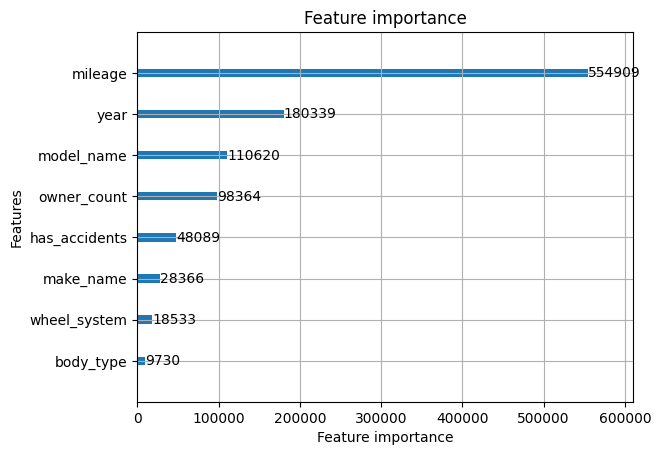

In [11]:
lgb.plot_importance(clf)

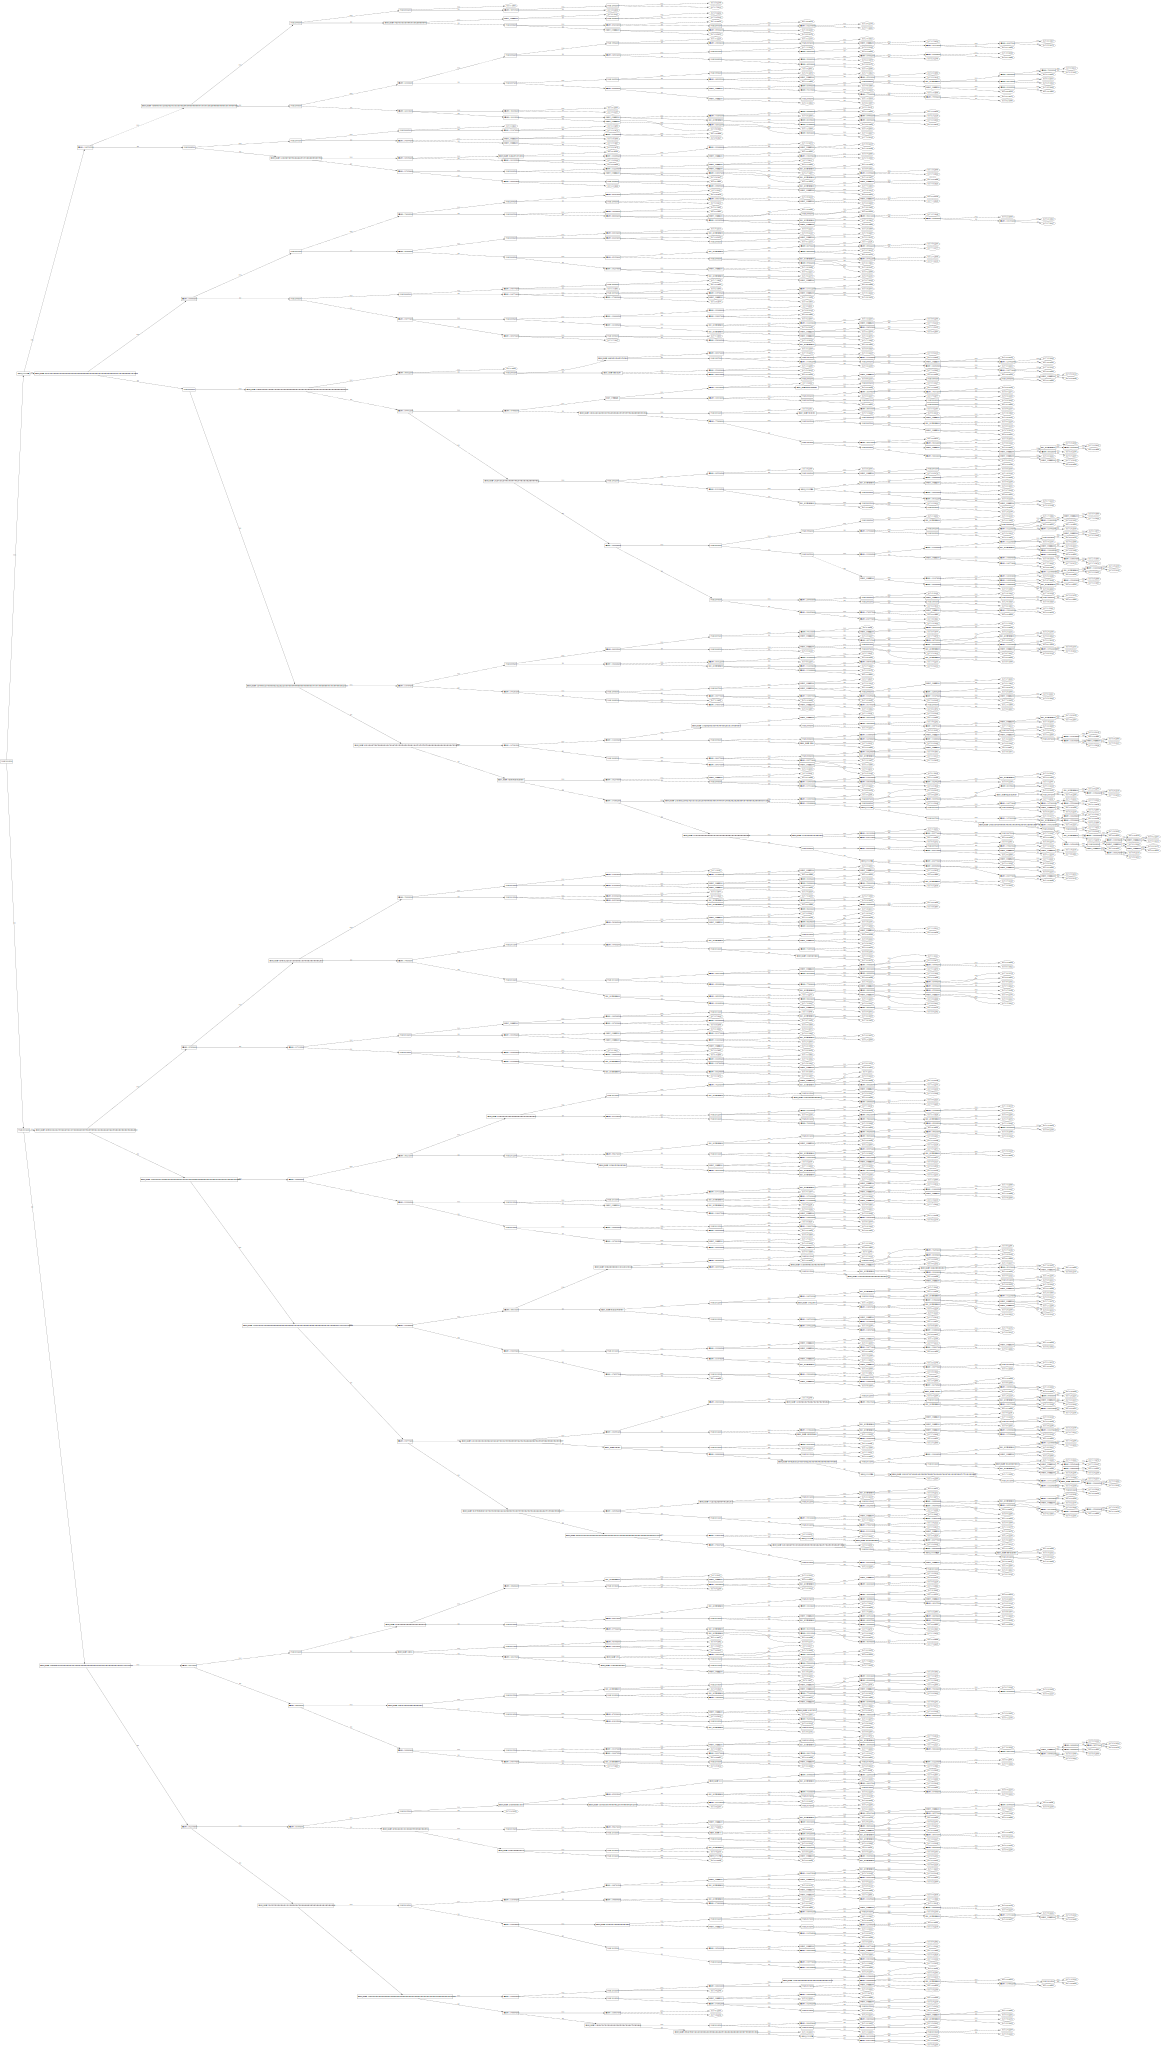

In [13]:
lgb.create_tree_digraph(clf)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='multi_logloss'>

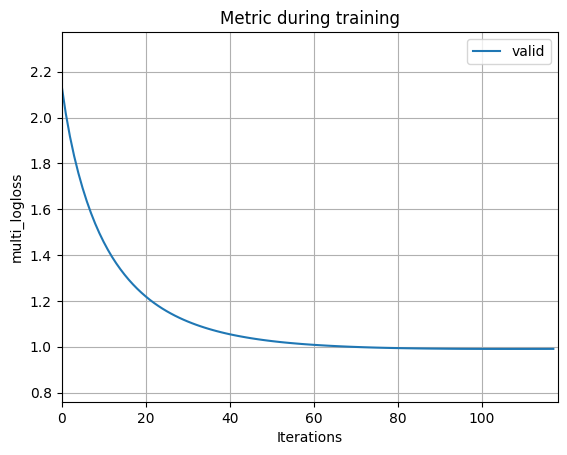

In [14]:
lgb.plot_metric(clf)

In [15]:
#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 1000 define only the absolute maximum
clf = lgb.LGBMClassifier(num_leaves= 11, max_depth=-1, 
                         random_state=314,  
                         metric='None', 
                         n_jobs=14, 
                         n_estimators=1000,
                         colsample_bytree=.9,
                         subsample=0.9,
                         learning_rate=0.1)


In [16]:
#force larger number of max trees and smaller learning rate
clf.fit(X_train, y_train, **fit_params)

c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid's multi_logloss: 2.09903
[2]	valid's multi_logloss: 1.97202
[3]	valid's multi_logloss: 1.88049
[4]	valid's multi_logloss: 1.79895
[5]	valid's multi_logloss: 1.72611
[6]	valid's multi_logloss: 1.66671
[7]	valid's multi_logloss: 1.61555
[8]	valid's multi_logloss: 1.56973
[9]	valid's multi_logloss: 1.53137
[10]	valid's multi_logloss: 1.4989
[11]	valid's multi_logloss: 1.46989
[12]	valid's multi_logloss: 1.44474
[13]	valid's multi_logloss: 1.42063
[14]	valid's multi_logloss: 1.39957
[15]	valid's multi_logloss: 1.37918
[16]	valid's multi_logloss: 1.36093
[17]	valid's multi_logloss: 1.3449
[18]	valid's multi_logloss: 1.3308
[19]	valid's multi_logloss: 1.3172
[20]	valid's multi_logloss: 1.30359
[21]	valid's multi_logloss: 1.29254
[22]	valid's multi_logloss: 1.28121
[23]	valid's multi_logloss: 1.27039
[24]	valid's multi_logloss: 1.26069
[25]	valid's multi_logloss: 1.2522
[26]	valid's multi_logloss: 1.24317
[27]	valid's multi_logloss: 1.23451
[28]	valid's multi_logloss: 1.22671
[29]	v

LGBMClassifier(colsample_bytree=0.9, metric='None', n_estimators=1000,
               n_jobs=14, num_leaves=11, random_state=314, subsample=0.9)

In [17]:
print('Testing accuracy {:.4f}'.format(clf.score(X_test,y_test)))

Testing accuracy 0.5720


In [18]:
print('Training accuracy {:.4f}'.format(clf.score(X_train,y_train)))


Training accuracy 0.5824


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

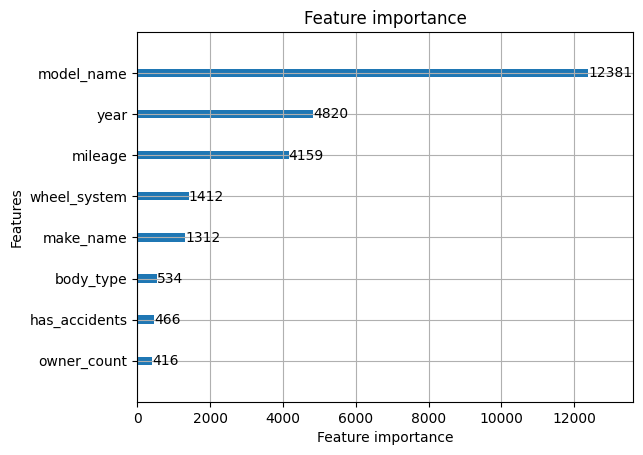

In [19]:
lgb.plot_importance(clf)

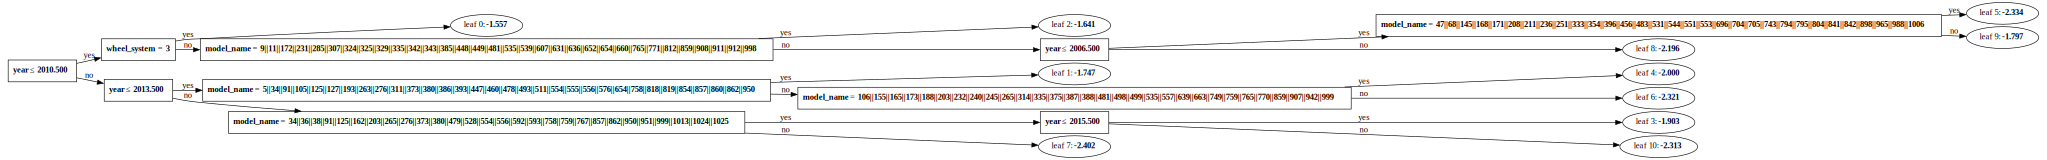

In [20]:
lgb.create_tree_digraph(clf)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='multi_logloss'>

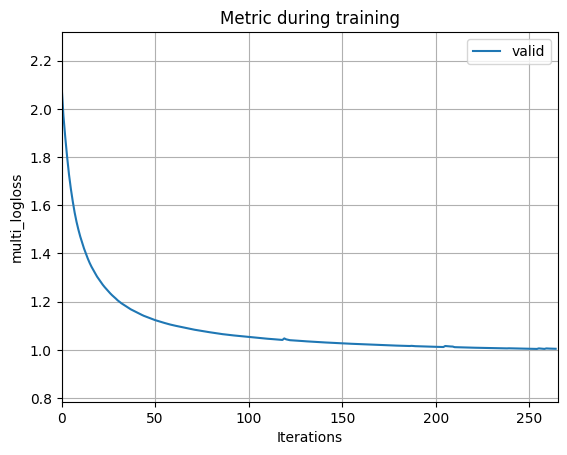

In [21]:
lgb.plot_metric(clf)

In [28]:
def rangeCheck(num, data):
    if num == 10:
        ranges = [
            (0, data.price.quantile(.1)),
            (data.price.quantile(.1), data.price.quantile(.2)),
            (data.price.quantile(.2), data.price.quantile(.3)),
            (data.price.quantile(.3), data.price.quantile(.4)),
            (data.price.quantile(.4), data.price.quantile(.5)),
            (data.price.quantile(.5), data.price.quantile(.6)),
            (data.price.quantile(.6), data.price.quantile(.7)),
            (data.price.quantile(.7), data.price.quantile(.8)),
            (data.price.quantile(.8), data.price.quantile(.9)),
            (data.price.quantile(.9), data.price.quantile(1)+1),
        ]
    elif num == 5:
        ranges = [
            (0, data.price.quantile(.2)),
            (data.price.quantile(.2), data.price.quantile(.4)),
            (data.price.quantile(.4), data.price.quantile(.6)),
            (data.price.quantile(.6), data.price.quantile(.8)),
            (data.price.quantile(.8), data.price.quantile(1)+1),
        ]
    elif num == 4:
        ranges = [
            (0, data.price.quantile(.25)),
            (data.price.quantile(.25), data.price.quantile(.5)),
            (data.price.quantile(.5), data.price.quantile(.75)),
            (data.price.quantile(.75), data.price.quantile(1)+1),
        ]
    else:
        ranges = [
            (0, data.price.quantile(.5)),
            (data.price.quantile(.5), data.price.quantile(1)+1),
        ]

    def findBucket(price):
        val = 0
        for startPrice, EndPrice in ranges:
            if price >= startPrice and price < EndPrice:
                return val
            val += 1

    data['bucket'] = data.apply(lambda row: findBucket(row['price']), axis=1)
    data['has_accidents'] = data['has_accidents'].astype(bool).astype('int64')


    X = data.drop(['price', 'listed_date', 'exterior_color', 'major_options', 'trim_name', 'dealer_zip', 'bucket'],axis=1)
    y = data.bucket
    del data
            
    for c in X.columns:
        col_type = X[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            X[c] = X[c].astype('category')
        if col_type == 'float64':
            X[c] = X[c].astype('int64')
    
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=320, stratify=y)

    fit_params={"early_stopping_rounds":100, 
            "eval_metric" : 'logloss', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'feature_name': 'auto', # that's actually the default
            'categorical_feature': 'auto' # that's actually the default
    }
    
    clf = lgb.LGBMClassifier(num_leaves= 15, max_depth=-1, 
                         random_state=314,  
                         metric='None', 
                         n_jobs=4, 
                         n_estimators=1000,
                         colsample_bytree=0.9,
                         subsample=0.9,
                         learning_rate=0.1)
    
    clf.fit(X_train, y_train, **fit_params)

    trainError = clf.score(X_train,y_train)
    testError = clf.score(X_test,y_test)

    print('Training accuracy {:.4f}'.format(trainError))
    print('Testing accuracy {:.4f}'.format(testError))

    lgb.plot_importance(clf)
    return trainError, testError,clf

c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid's binary_logloss: 0.632339
[2]	valid's binary_logloss: 0.581819
[3]	valid's binary_logloss: 0.544558
[4]	valid's binary_logloss: 0.505337
[5]	valid's binary_logloss: 0.472545
[6]	valid's binary_logloss: 0.444276
[7]	valid's binary_logloss: 0.419157
[8]	valid's binary_logloss: 0.397423
[9]	valid's binary_logloss: 0.377939
[10]	valid's binary_logloss: 0.361138
[11]	valid's binary_logloss: 0.345995
[12]	valid's binary_logloss: 0.332391
[13]	valid's binary_logloss: 0.322535
[14]	valid's binary_logloss: 0.311356
[15]	valid's binary_logloss: 0.301151
[16]	valid's binary_logloss: 0.292078
[17]	valid's binary_logloss: 0.283512
[18]	valid's binary_logloss: 0.276069
[19]	valid's binary_logloss: 0.270765
[20]	valid's binary_logloss: 0.264743
[21]	valid's binary_logloss: 0.258261
[22]	valid's binary_logloss: 0.253336
[23]	valid's binary_logloss: 0.249636
[24]	valid's binary_logloss: 0.246333
[25]	valid's binary_logloss: 0.241657
[26]	valid's binary_logloss: 0.237518
[27]	valid's binary_l

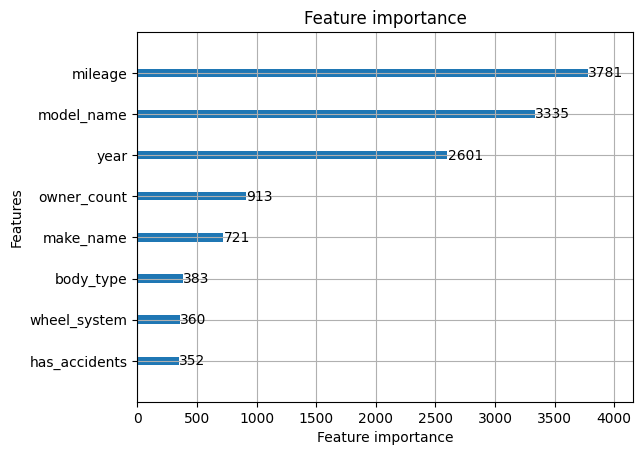

In [29]:
trainError2, testError2,clf = rangeCheck(2, data)

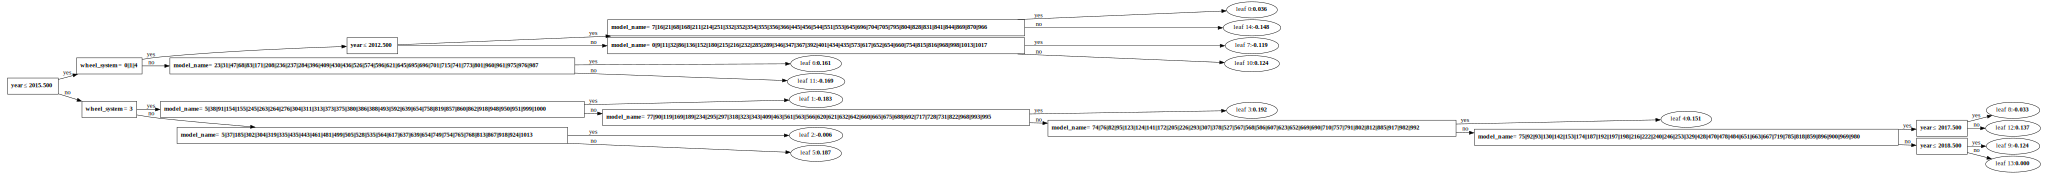

In [30]:
lgb.create_tree_digraph(clf)


c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid's multi_logloss: 1.25673
[2]	valid's multi_logloss: 1.14958
[3]	valid's multi_logloss: 1.06339
[4]	valid's multi_logloss: 0.992525
[5]	valid's multi_logloss: 0.937459
[6]	valid's multi_logloss: 0.894507
[7]	valid's multi_logloss: 0.848873
[8]	valid's multi_logloss: 0.813333
[9]	valid's multi_logloss: 0.78027
[10]	valid's multi_logloss: 0.752227
[11]	valid's multi_logloss: 0.72448
[12]	valid's multi_logloss: 0.70041
[13]	valid's multi_logloss: 0.677934
[14]	valid's multi_logloss: 0.659745
[15]	valid's multi_logloss: 0.642909
[16]	valid's multi_logloss: 0.627327
[17]	valid's multi_logloss: 0.612748
[18]	valid's multi_logloss: 0.600617
[19]	valid's multi_logloss: 0.589488
[20]	valid's multi_logloss: 0.577969
[21]	valid's multi_logloss: 0.569367
[22]	valid's multi_logloss: 0.561421
[23]	valid's multi_logloss: 0.552991
[24]	valid's multi_logloss: 0.545753
[25]	valid's multi_logloss: 0.538948
[26]	valid's multi_logloss: 0.532811
[27]	valid's multi_logloss: 0.526583
[28]	valid's mul

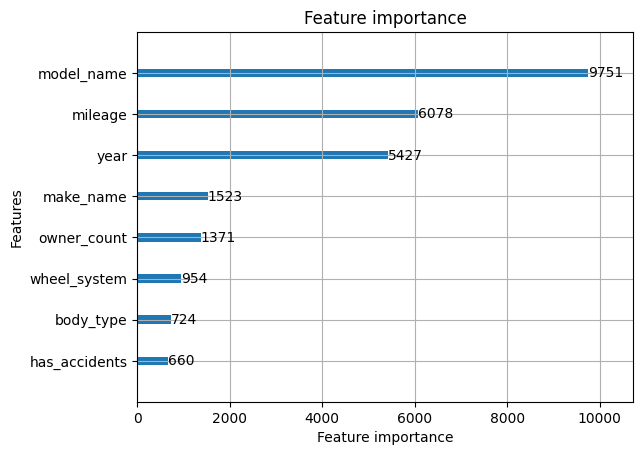

In [31]:
trainError4, testError4,clf = rangeCheck(4, data)

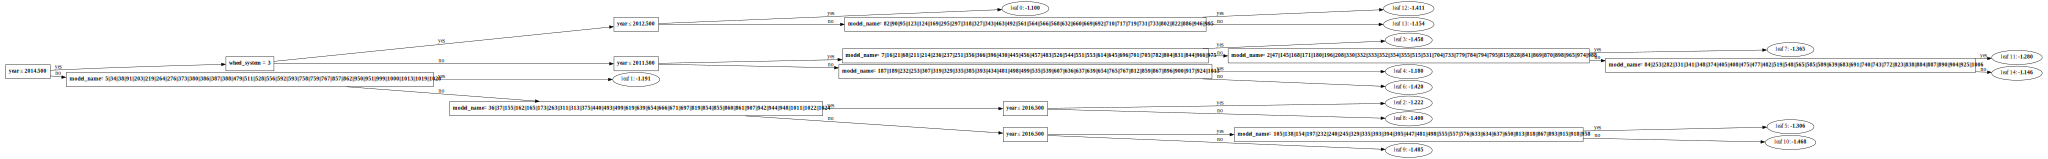

In [32]:
lgb.create_tree_digraph(clf)


c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid's multi_logloss: 1.45806
[2]	valid's multi_logloss: 1.33435
[3]	valid's multi_logloss: 1.24404
[4]	valid's multi_logloss: 1.17022
[5]	valid's multi_logloss: 1.11111
[6]	valid's multi_logloss: 1.0608
[7]	valid's multi_logloss: 1.01414
[8]	valid's multi_logloss: 0.971956
[9]	valid's multi_logloss: 0.934118
[10]	valid's multi_logloss: 0.901924
[11]	valid's multi_logloss: 0.873485
[12]	valid's multi_logloss: 0.848896
[13]	valid's multi_logloss: 0.825808
[14]	valid's multi_logloss: 0.806549
[15]	valid's multi_logloss: 0.789319
[16]	valid's multi_logloss: 0.772444
[17]	valid's multi_logloss: 0.759553
[18]	valid's multi_logloss: 0.746862
[19]	valid's multi_logloss: 0.734859
[20]	valid's multi_logloss: 0.723453
[21]	valid's multi_logloss: 0.712709
[22]	valid's multi_logloss: 0.703374
[23]	valid's multi_logloss: 0.695348
[24]	valid's multi_logloss: 0.687762
[25]	valid's multi_logloss: 0.680343
[26]	valid's multi_logloss: 0.672176
[27]	valid's multi_logloss: 0.665522
[28]	valid's multi

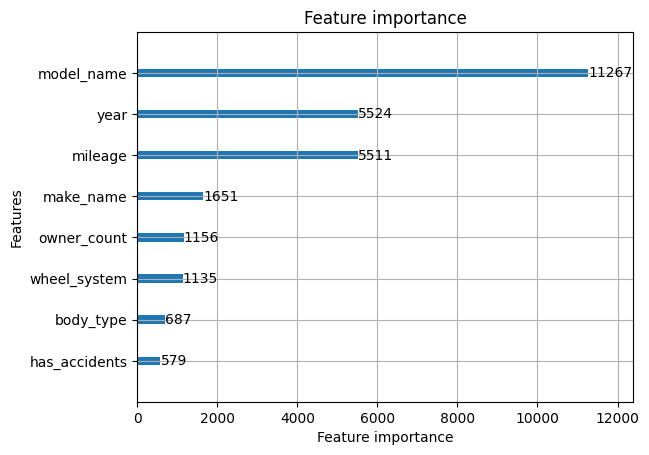

In [33]:
trainError5, testError5, clf = rangeCheck(5, data)

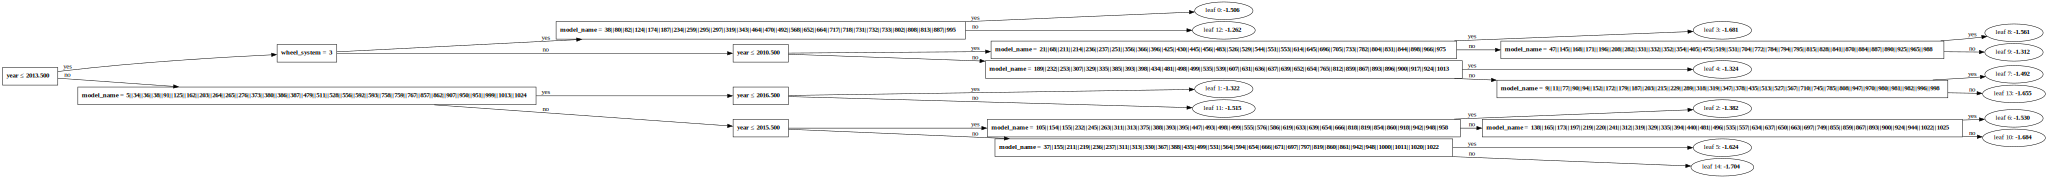

In [34]:
lgb.create_tree_digraph(clf)


c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid's multi_logloss: 2.08855
[2]	valid's multi_logloss: 1.95486
[3]	valid's multi_logloss: 1.85796
[4]	valid's multi_logloss: 1.77309
[5]	valid's multi_logloss: 1.69737
[6]	valid's multi_logloss: 1.6339
[7]	valid's multi_logloss: 1.58063
[8]	valid's multi_logloss: 1.53518
[9]	valid's multi_logloss: 1.49699
[10]	valid's multi_logloss: 1.46271
[11]	valid's multi_logloss: 1.43225
[12]	valid's multi_logloss: 1.40704
[13]	valid's multi_logloss: 1.38158
[14]	valid's multi_logloss: 1.36056
[15]	valid's multi_logloss: 1.34048
[16]	valid's multi_logloss: 1.32207
[17]	valid's multi_logloss: 1.30565
[18]	valid's multi_logloss: 1.29088
[19]	valid's multi_logloss: 1.27718
[20]	valid's multi_logloss: 1.26367
[21]	valid's multi_logloss: 1.25222
[22]	valid's multi_logloss: 1.24055
[23]	valid's multi_logloss: 1.23013
[24]	valid's multi_logloss: 1.2204
[25]	valid's multi_logloss: 1.21079
[26]	valid's multi_logloss: 1.20187
[27]	valid's multi_logloss: 1.19355
[28]	valid's multi_logloss: 1.18645
[29

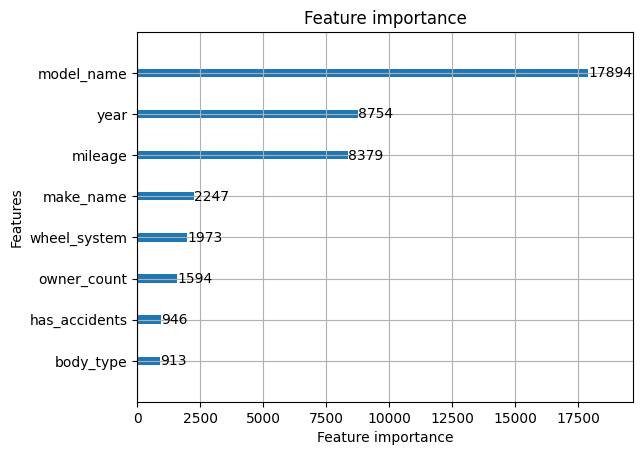

In [35]:
trainError10, testError10,clf = rangeCheck(10, data)

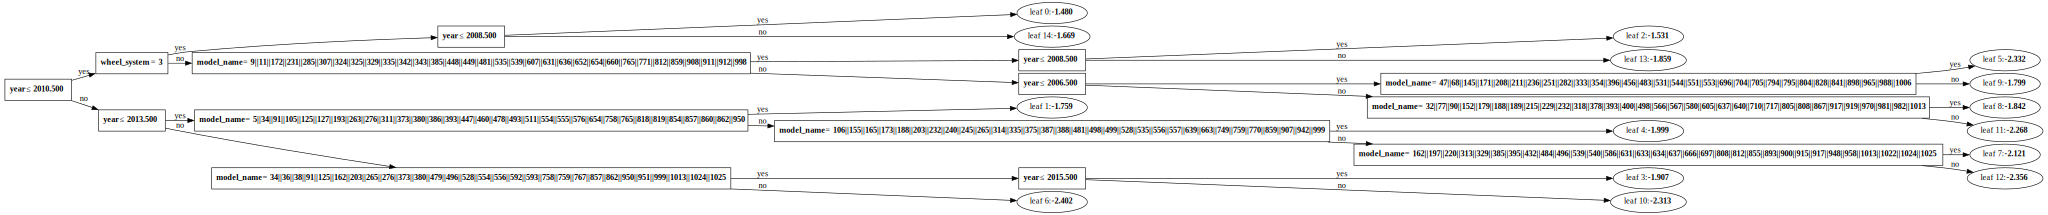

In [36]:
lgb.create_tree_digraph(clf)

In [37]:
x = {
    2: testError2,
    4: testError4,
    5: testError5,
    10: testError10
}

for k in x.keys():
    print(f"Test error with {k} Percentile Buckets is {x[k]}")

Test error with 2 Percentile Buckets is 0.9221206874117965
Test error with 4 Percentile Buckets is 0.8231200768684129
Test error with 5 Percentile Buckets is 0.7745468466935572
Test error with 10 Percentile Buckets is 0.5748616268478947
